In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import binom
from scipy.stats import norm
import itertools

Basic Descriptive Statistics for Each Stock:
            mean       std       min       max    median
TICKER                                                  
EIX     0.000434  0.016748 -0.133333  0.153846  0.000855
NKE     0.000665  0.017972 -0.128081  0.155314  0.000504
ZTS     0.000873  0.016187 -0.146956  0.119793  0.001102

Detailed Descriptive Statistics for Each Stock:
         count      mean       std       min       25%       50%       75%  \
TICKER                                                                       
EIX     2268.0  0.000434  0.016748 -0.133333 -0.006621  0.000855  0.008878   
NKE     2268.0  0.000665  0.017972 -0.128081 -0.007699  0.000504  0.009602   
ZTS     2268.0  0.000873  0.016187 -0.146956 -0.006790  0.001102  0.008874   

             max  
TICKER            
EIX     0.153846  
NKE     0.155314  
ZTS     0.119793  

Descriptive Statistics for Stock Returns and Market Returns:
        Unnamed: 0        PERMNO  stock_return        SHROUT         RETX

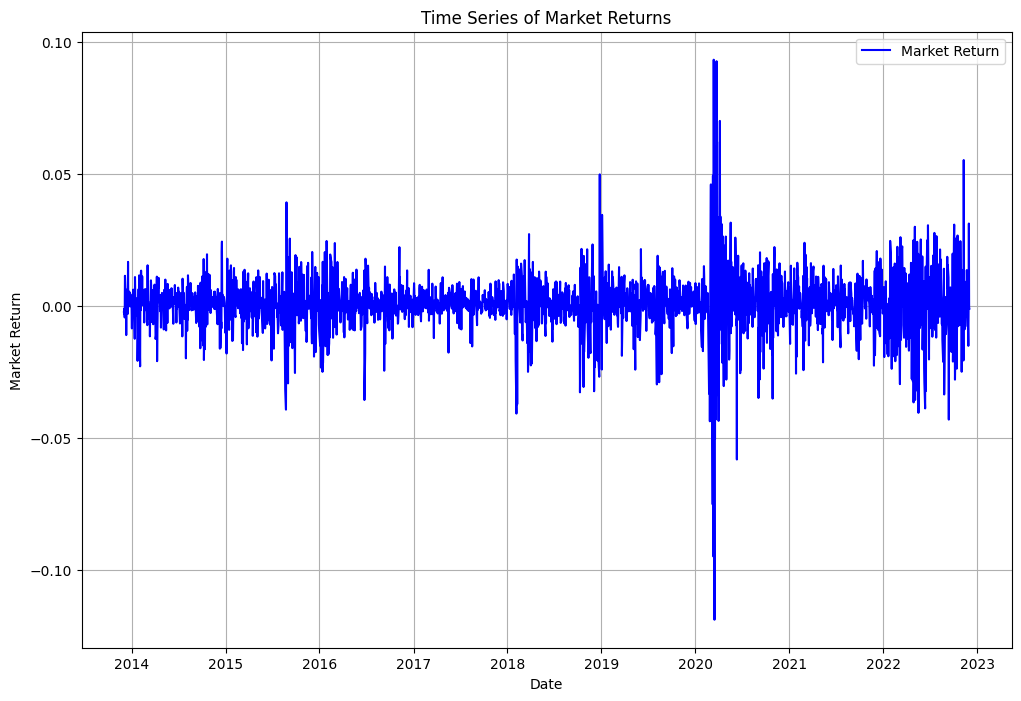

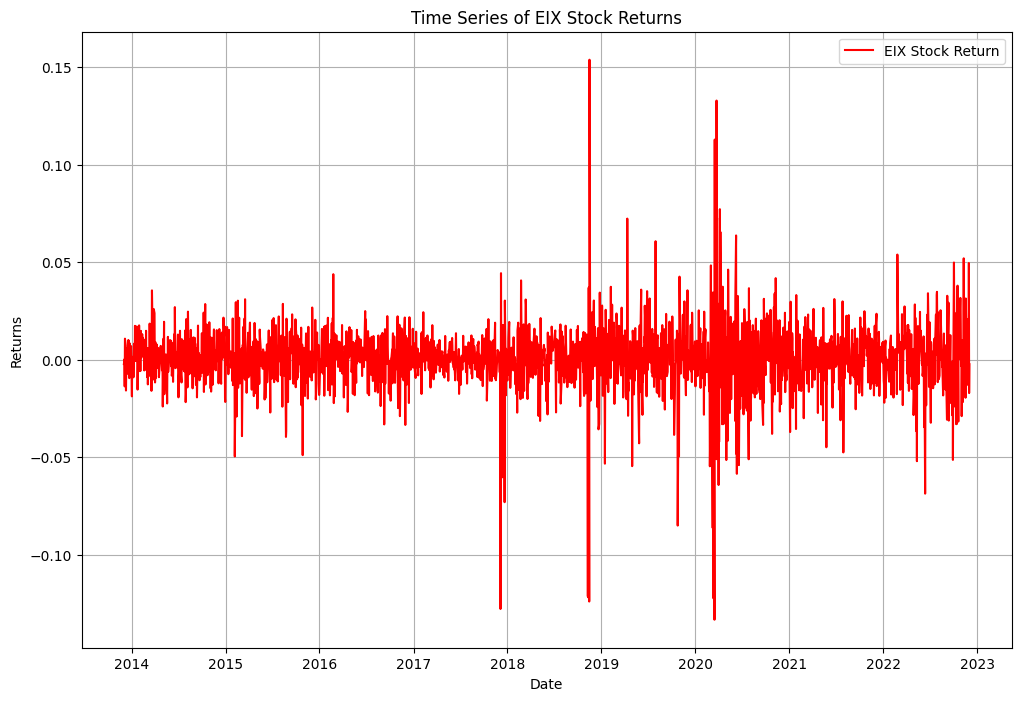

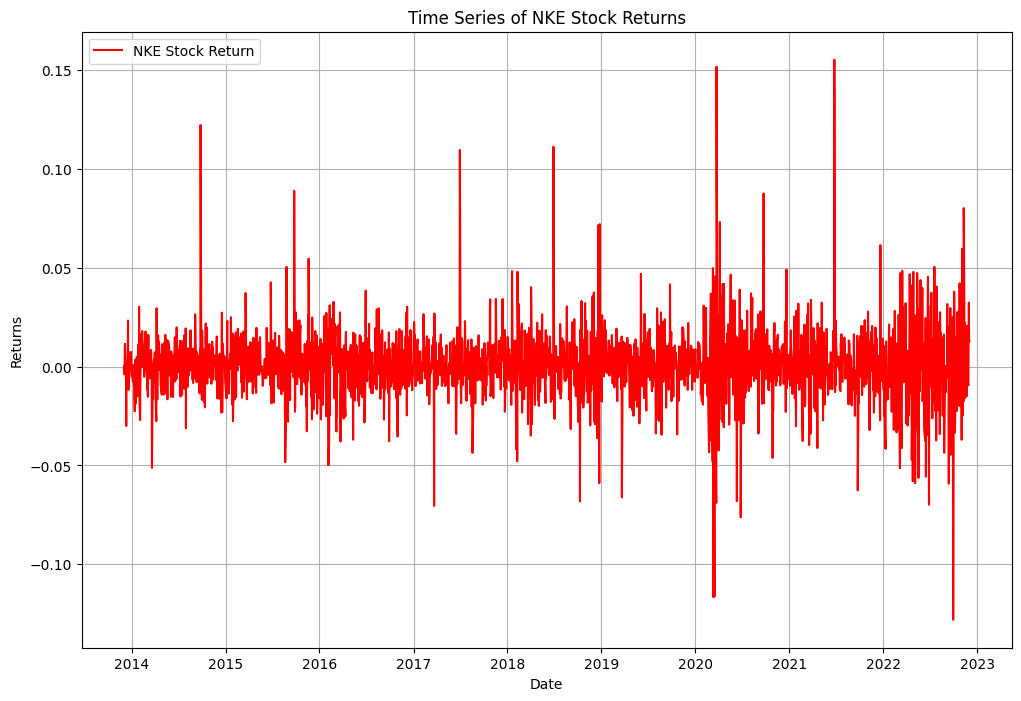

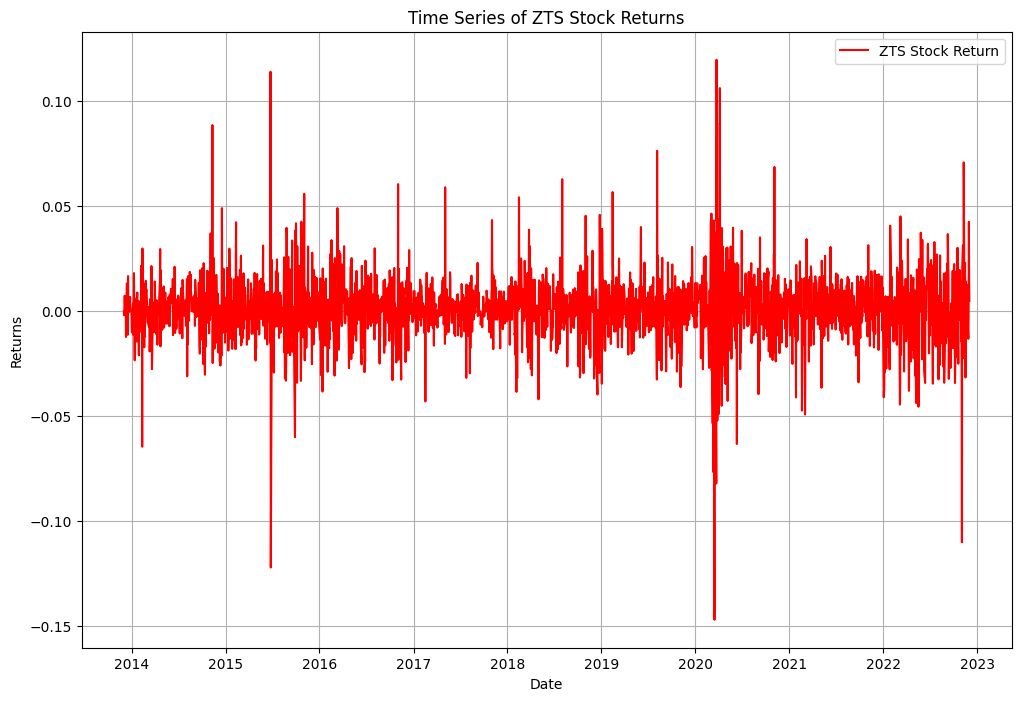

In [2]:

#question a
data = pd.read_csv('Merged_Market_and_Stock_Returns.csv', parse_dates=['date'])
data.set_index('date', inplace=True)
grouped = data.groupby('TICKER')
basic_stats = grouped['stock_return'].agg(['mean', 'std', 'min', 'max', 'median'])

print("Basic Descriptive Statistics for Each Stock:")
print(basic_stats)
detailed_stats = grouped['stock_return'].describe()
print("\nDetailed Descriptive Statistics for Each Stock:")
print(detailed_stats)

# describe the stats
descriptive_stats = data.describe()  

print("\nDescriptive Statistics for Stock Returns and Market Returns:")
print(descriptive_stats)

# plot the market return
plt.figure(figsize=(12, 8))
plt.plot(data['market_return'], label='Market Return', color='blue')
plt.title('Time Series of Market Returns')
plt.xlabel('Date')
plt.ylabel('Market Return')
plt.legend()
plt.grid(True)
plt.show()

# plot the stock return for 3 stocks
for name, group in grouped:
    plt.figure(figsize=(12, 8))
    plt.plot(group['stock_return'], label=f'{name} Stock Return', color='red')
    plt.title(f'Time Series of {name} Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.grid(True)
    plt.show() 



In [6]:

#question b
def VaR_expectedshortfall(returns, alpha):

    # get the return with np
    returns = np.array(returns)
    
    # calculate the VaR by using the quantile at the alpha level
    var = np.quantile(returns, alpha)
    
    # calculate expected shortfall
    es = returns[returns <= var].mean()
    
    return var, es



returns_eix = data[data['TICKER'] == 'EIX']['market_return'].dropna().values
returns_zts = data[data['TICKER'] == 'ZTS']['market_return'].dropna().values
returns_nike = data[data['TICKER'] == 'NKE']['market_return'].dropna().values

#define the CI, here is 1-CI of aloha
alpha = 0.05

results = {}
for ticker in data['TICKER'].unique():
    returns = data[data['TICKER'] == ticker]['stock_return']
    var, es = VaR_expectedshortfall(returns, alpha)
    results[ticker] = (var, es)

# output
for ticker, (var, es) in results.items():
    print(f"{ticker} - VaR ({alpha*100}%): {var:.4f}, ES ({alpha*100}%): {es:.4f}")



ZTS - VaR (5.0%): -0.0241, ES (5.0%): -0.0365
EIX - VaR (5.0%): -0.0225, ES (5.0%): -0.0405
NKE - VaR (5.0%): -0.0262, ES (5.0%): -0.0401


In [7]:

#question c
def VaR_with_ols_method(regression_results, p):
    sigma_ols = regression_results.scale**0.5
    z_p = -np.percentile(np.random.normal(0, 1, 10000), 100 * (1 - p))
    VaR = sigma_ols * z_p
    return VaR

#setting up alpha
alpha = 0.05  

# get the result of EIX, NKE,ZTS as some result to show
stock_names = ['EIX', 'NKE', 'ZTS']
vars_results = {}
for stock in stock_names:
    X = sm.add_constant(data['market_return'])  
    y = data["stock_return"]  
    model = sm.OLS(y, X)
    results = model.fit()
    VaR = VaR_with_ols_method(results, alpha)
    vars_results[stock] = VaR

# output
for stock, VaR in vars_results.items():
    print(f"VaR for {stock} at confidence level {alpha}: {VaR:.4f}")




VaR for EIX at confidence level 0.05: -0.0222
VaR for NKE at confidence level 0.05: -0.0214
VaR for ZTS at confidence level 0.05: -0.0226


In [18]:
#question d

def VaR_dynamic(residuals, alpha, initial_sigma_squared):
    n = len(residuals)
    sigma_squared = np.zeros(n)
    sigma_squared[0] = initial_sigma_squared
    #define the function by what is given in the question(it is likely to be the garach(1,1))
    for t in range(1, n):
        sigma_squared[t] = (initial_sigma_squared / 2) + (sigma_squared[t-1] / 2)  
    
    sigma = np.sqrt(sigma_squared)
    z_p = -np.percentile(np.random.normal(0, 1, 10000), 100 * (1 - alpha))
    VaRs = sigma * z_p
    return VaRs

# making the data from the stock 
results_dict = {}
for ticker in data['TICKER'].unique():
    stock_data = data[data['TICKER'] == ticker]
    #the market return is the X
    X = sm.add_constant(stock_data['market_return'])  
    #stock return is set as the dependent varaiable
    y = stock_data['stock_return']  
    model = sm.OLS(y, X)
    results = model.fit()
    
    # find the inistial sigma square
    initial_sigma_squared = np.var(results.resid)
    
    # calculating the var of dynamic
    VaRs = VaR_dynamic(results.resid, 0.05, initial_sigma_squared)
    
    # save the result for last time step
    results_dict[ticker] = VaRs[-1]  

# output
for ticker, VaR in results_dict.items():
    print(f"Dynamic VaR for {ticker} at last time step: {VaR}")
    

Dynamic VaR for ZTS at last time step: -0.02009083448811065
Dynamic VaR for EIX at last time step: -0.024343099848022832
Dynamic VaR for NKE at last time step: -0.022177175197404763


In [24]:
#question e
def The_VaR(returns, confidence_level):
    """
    Calculate Value-at-Risk (VaR) for a series of returns and a given confidence level.
    """
    var = np.percentile(returns, 100 * (1 - confidence_level))
    return var

def VaRcoverage_test(returns, var, p):
    """
    Test if the Value-at-Risk (VaR) has appropriate coverage.
    """
    hits = np.sum(returns <= var)
    n = len(returns)
    expected_hits = p * n
    std_dev = np.sqrt(n * p * (1 - p))
    test_statistic = (hits - expected_hits) / std_dev
    p_value = 2 * norm.cdf(-np.abs(test_statistic))
    accept_null = p_value > 0.05
    return p_value, test_statistic, accept_null



# Group data by TICKERs
grouped_data = data.groupby('TICKER')

# Confidence level 
confidence_level = 0.95

# Results dictionary
results = {}

# Process each group
for ticker, group in grouped_data:
    # Calculate VaR for each stock
    stock_returns = group['stock_return'].dropna()
    var = The_VaR(stock_returns, confidence_level)
    
    # Run the VaR coverage test
    p_val, test_stat, accept_null = VaRcoverage_test(stock_returns, var, 1 - confidence_level)
    
    # Store results
    results[ticker] = {
        'VaR': var,
        'P-value': p_val,
        'Test Statistic': test_stat,
        'Accept Null Hypothesis': accept_null
    }

# Print the results
for ticker, result in results.items():
    print(f"{ticker}: VaR: {result['VaR']:.4f}, P-value: {result['P-value']:.4f}, Test Statistic: {result['Test Statistic']:.4f}, Accept Null: {result['Accept Null Hypothesis']}")

EIX: VaR: -0.0225, P-value: 0.9539, Test Statistic: 0.0578, Accept Null: True
NKE: VaR: -0.0262, P-value: 0.9539, Test Statistic: 0.0578, Accept Null: True
ZTS: VaR: -0.0241, P-value: 0.9539, Test Statistic: 0.0578, Accept Null: True


In [25]:
#calculate the part for market return
unique_data=data.drop_duplicates(subset=["date"])
unique_data
market_returns=unique_data["market_return"]

# stock_returns = group['stock_return'].dropna()
var = The_VaR(market_returns, confidence_level)

# Run the VaR coverage test
p_val, test_stat, accept_null = VaRcoverage_test(market_returns, var, 1 - confidence_level)

# Store results
results_market = {
    'VaR': var,
    'P-value': p_val,
    'Test Statistic': test_stat,
    'Accept Null Hypothesis': accept_null
}
# for ticker, result in results.items():
print(f"market_returns: VaR: {results_market['VaR']:.4f}, P-value: {results_market['P-value']:.4f}, Test Statistic: {results_market['Test Statistic']:.4f}, Accept Null: {results_market['Accept Null Hypothesis']}")

market_returns: VaR: -0.0173, P-value: 0.9539, Test Statistic: 0.0578, Accept Null: True


In [21]:
#question f


def The_VaR(returns, confidence_level):
    """
    Calculate VaR for a given confidence level.
    """
    return np.percentile(returns, 100 * (1 - confidence_level))

def Using_wald_wolfowitz_test(binary_data):
    """
    Perform the Wald-Wolfowitz Runs Test for randomness on binary data.
    """
    n1 = np.sum(binary_data == 1)
    n2 = np.sum(binary_data == 0)
    # Calculate the number of runs using .iloc for safe position-based indexing
    runs = 1 + sum(binary_data.iloc[i] != binary_data.iloc[i+1] for i in range(len(binary_data) - 1))

    expected_runs = 1 + 2 * n1 * n2 / (n1 + n2)
    var_runs = 2 * n1 * n2 * (2 * n1 * n2 - n1 - n2) / ((n1 + n2)**2 * (n1 + n2 - 1))
    z = (runs - expected_runs) / np.sqrt(var_runs)
    p_value = 2 * norm.cdf(-np.abs(z))  # Two-tailed test

    return runs, expected_runs, var_runs, z, p_value


confidence_level = 0.95
stocks = ['EIX', 'NKE', 'ZTS', 'market']
results = {}

for ticker in stocks:
    returns = data[data['TICKER'] == ticker]['stock_return'] if ticker != 'market' else data['market_return']
    var = The_VaR(returns, confidence_level)
    # 1 for hits, 0 for non-hits, for binary
    binary_returns = returns < var  
    runs, expected_runs, var_runs, z, p_value = Using_wald_wolfowitz_test(binary_returns)
    results[ticker] = {'Observed Runs': runs, 'Expected Runs': expected_runs,
                       'Variance of Runs': var_runs, 'Z-score': z, 'P-value': p_value}

# output
for ticker, result in results.items():
    print(f"{ticker} Results:")
    print(f"  Observed Runs: {result['Observed Runs']}")
    print(f"  Expected Runs: {result['Expected Runs']:.2f}")
    print(f"  Variance of Runs: {result['Variance of Runs']:.2f}")
    print(f"  Z-score: {result['Z-score']:.2f}")
    print(f"  P-value: {result['P-value']:.12f}")
    print("Random sequence detected" if result['P-value'] > 0.05 else "Non-random sequence detected")
    print()


EIX Results:
  Observed Runs: 201
  Expected Runs: 217.54
  Variance of Runs: 20.59
  Z-score: -3.65
  P-value: 0.000267190904
Non-random sequence detected

NKE Results:
  Observed Runs: 197
  Expected Runs: 217.54
  Variance of Runs: 20.59
  Z-score: -4.53
  P-value: 0.000005989593
Non-random sequence detected

ZTS Results:
  Observed Runs: 195
  Expected Runs: 217.54
  Variance of Runs: 20.59
  Z-score: -4.97
  P-value: 0.000000678083
Non-random sequence detected

market Results:
  Observed Runs: 197
  Expected Runs: 645.22
  Variance of Runs: 60.91
  Z-score: -57.43
  P-value: 0.000000000000
Non-random sequence detected

